# Kernels and SVM

## Intro

In [196]:
# import libraries
from IPython.display import Image
from IPython.core.display import HTML 

import pandas as pd
import numpy as np
import os

from pydataset import data

# to make this notebook's output stable across runs
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

## visualizing transformations and kernels

Support vector classification relies on this notion of linearly separable data. Soft margin classification can accommodate some classification errors on the training data, where the tolerance for misclassification errors is controlled by the regularization parameter C. However, data is often very far from being linearly separable. 

In this case, we apply transformations to the data, which maps the data from the original feature space into higher dimensions. The goal is that after the transformation to the higher dimensional space, the classes are now linearly separable **in this higher dimensional space**. We can then fit a decision boundary to separate the classes and make predictions, where the decision boundary is a linear hyperplane in this higher dimensional space. <br>
<br>
It is obviously hard to visualize this decision boundary and how the transformed data is linearly separable in higher dimensions, but remember our mathematical definition of linearity and the hyperplane equation.  

We first look at a few transformations applied to 1 dimensional data

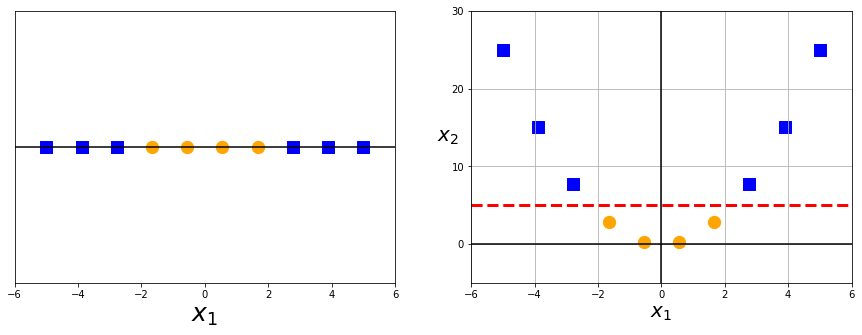

In [198]:
x1 = np.linspace(-5, 5, 10).reshape(-1, 1)
x2 = x1**2
x2 = x2.reshape(-1, 1)
y = np.array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0])

class1 = x1[y == 0]
class2 = x1[y == 1]

plt.figure(figsize=(15, 5))
plt.subplot(121)

plt.scatter(class1, np.zeros(6), marker = 's', color = 'blue', s = 150)
plt.scatter(class2, np.zeros(4), color = 'orange', s = 150)
plt.axhline(y=0, color='k')
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=25)
plt.axis([-6, 6, -0.5, 0.5])

plt.subplot(122)
plt.scatter(class1, class1**2, marker = 's', color = 'blue', s = 150)
plt.scatter(class2, class2**2, color = 'orange', s = 150)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 10, 20, 30])
plt.plot([-6, 6], [5, 5], "r--", linewidth=3)
plt.axis([-6, 6, -5, 30]);

The original one dimensional data could not be linearly separated, but after applying the transformation and plotting $\phi(x) = x^2$, the data is linearly separable in the new 2-D space. <br>
<br>
For now we are just examining transformations to higher dimensions that allow the data to be linearly separated. These are just functions, and there are many possible functions that can map the data to any number of higher dimensions.

Another 1D -> 2D example where $\phi(x) = x \ mod \ 2$

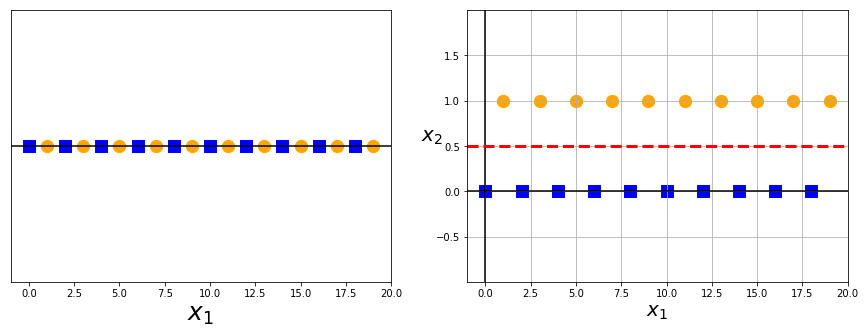

In [199]:
x1 = np.arange(20).reshape(-1, 1)
x2 = x1 % 2
y = np.tile([0,1], 10)
class1 = x1[y == 0]
class2 = x1[y == 1]

plt.figure(figsize=(15, 5))
plt.subplot(121)

plt.scatter(class1, np.zeros(10), marker = 's', color = 'blue', s = 150)
plt.scatter(class2, np.zeros(10), color = 'orange', s = 150)
plt.axhline(y=0, color='k')
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=25)
plt.axis([-1, 20, -0.5, 0.5])

plt.subplot(122)
plt.scatter(class1, class1 % 2, marker = 's', color = 'blue', s = 150)
plt.scatter(class2, class2 % 2, color = 'orange', s = 150)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([-0.5, 0, 0.5, 1, 1.5])
plt.plot([-1, 20], [0.5, 0.5], "r--", linewidth=3)
plt.axis([-1, 20, -1, 2]);

### 2D transforms

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


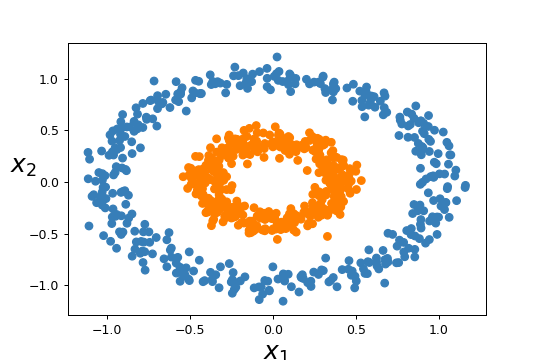

<IPython.core.display.Javascript object>


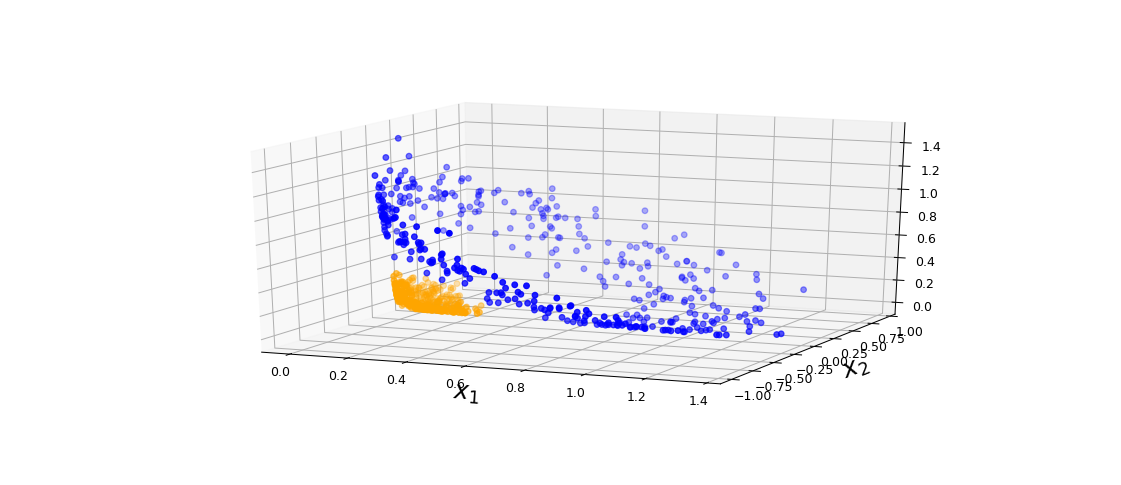

Text(0.5,0,'$x_1$')

Text(0.5,0,'$x_2$')

In [188]:
from sklearn.datasets import make_circles, make_blobs, make_moons
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle, islice

# set options for rendering plots
%matplotlib

visualization=True

def create_data():
    x,y=make_circles(n_samples=800,noise=.07, factor = 0.4)
    if visualization:
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y) + 1))))
        plt.scatter(x[:,0],x[:,1], color=colors[y]);
        plt.xlabel(r"$x_1$", fontsize=20);
        plt.ylabel(r"$x_2$", fontsize=20, rotation=0);
        plt.show();
    return x,y

def project_data(data):
    x=data[:,0]**2
    y=np.sqrt(2)*data[:,1]*data[:,0] 
    z=data[:,1]**2
    return x,y,z

data,label=create_data()
x,y,z=project_data(data)
if visualization:
    fig = plt.figure(figsize = (12, 5));
    ax = fig.add_subplot(111, projection='3d');
    ax.scatter(x[label==0],y[label==0],z[label==0],c='blue');
    ax.scatter(x[label==1],y[label==1],z[label==1],c='orange');
    plt.xlabel(r"$x_1$", fontsize=20);
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0);
    plt.show();

There can be many transformations that allow the data to be linearly separated in higher dimensions, but not all of these functions are actually kernels. The kernel function has a special property that makes it particularly useful in training support vector models, and this property is often called the kernel trick.

# The kernel trick

We have seen how higher dimensional transformations can allow us to separate data in order to make classification predictions. It seems that in order to train a support vector classifier and optimize our constrained cost function, we would have to perform operations with the high dimensional vectors in the transformed feature space. In real applications, there might be many features in the data and applying transformations that involve polynomial combinations of these features will lead to extremely high and impractical computational costs. <br>
<br>
The **kernel trick** provides a solution to this problem. The "trick" is that kernel methods represent the data only through a set of pairwise similarity comparisons between the original data observations $x_i$, instead of representing the data by the individual, explicit transformations $\phi(x_i)$. <br>
<br>
In kernel methods, the data set **X** is represented by an n x n matrix of pairwise comparisons where the entries are defined by $k_{i,j} = k(x_i, x_j)$ <br>
<br>
This function k(x) is the kernel function, and it can be thought of as a measure of similarity between data points. It seems like witchcraft that we can find an optimal hyperplane in the feature space without having to explicitly calculate $\phi(x)$ , but I will attempt to provide at least some basic intuition. First, let's explore some common kernels and how they act as measures of similarity between data observations.

### Gaussian RBF and similarity measures

The Gaussian Radial Basis Function, or the Gaussian kernel, is given by: <br>
$$K(x, x') = exp^{-\gamma || x - x' || ^2}$$
<br>
where $\gamma$ is a regularization parameter, **x, x'** are vectors

We first choose one of our data points to be x' and then we calculate the pairwise Gaussian kernels between this point and our other data points x. <br>
<br>
x' is sometimes called a *landmark* because the Gaussian function will be a bell-shaped curve centered at x'. The height of the curve will measure the similarity between x' and the other data points. 

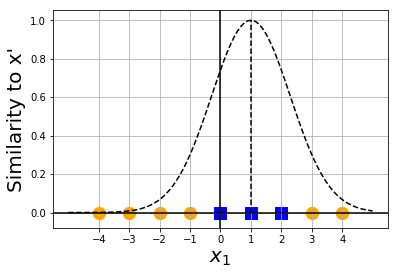

In [219]:
def gauss_ker(gamma, x, l):
    return np.exp(-gamma*(np.linalg.norm(x - l, axis=1)**2))

# set the landmark point at x = 1
%matplotlib inline
x = np.linspace(-5, 5, 100).reshape(-1, 1)
y = gauss_ker(0.3, x, 1)
x1 = np.arange(-4, 5).reshape(-1, 1)
labels = np.array([0, 0, 0, 0, 1, 1, 1, 0, 0])

plt.scatter(x1[labels == 0], np.zeros(6), marker = 'o', s = 150, color = 'orange')
plt.scatter(x1[labels == 1], np.zeros(3), marker = 's', s = 150, color = 'blue')

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity to x'", fontsize=20)
plt.gca().get_xaxis().set_ticks(np.arange(-4, 5))
plt.plot([1, 1], [0, 1], "k--")
plt.plot(x, y, "k--");

Note that if we use this similarity measure, which is essentially a weighted distance from our landmark point x' = 1, and add another dimension to the feature space we can linearly separate our data.

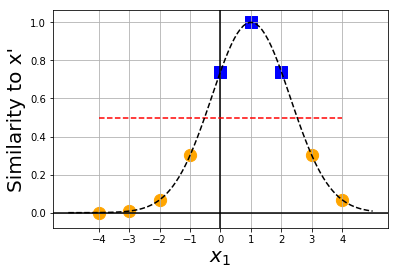

In [218]:
%matplotlib inline
x1 = np.arange(-4, 5).reshape(-1, 1)
x2 = gauss_ker(0.3, x1, 1)

labels = np.array([0, 0, 0, 0, 1, 1, 1, 0, 0])

plt.scatter(x1[labels == 0], x2[labels == 0], marker = 'o', s = 150, color = 'orange')
plt.scatter(x1[labels == 1], x2[labels == 1], marker = 's', s = 150, color = 'blue')

plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity to x'", fontsize=20)
plt.gca().get_xaxis().set_ticks(np.arange(-4, 5))
plt.plot([-4, 4], [0.5, 0.5], "r--")
plt.plot(x, y, "k--");

We used only one landmark and measured the similarity between that point and all other points. Assuming data in the same classes are generally in clusters or neighborhoods, using the Gaussian kernel we can separate the classes in higher dimensions. <br>
<br>
Now let's choose all data points as landmarks, and measure all the pairwise Gaussian kernels to find our n x n matrix representation.

In [235]:
def gauss_ker(gamma, x, l):
    return np.exp(-gamma*(np.linalg.norm(x - l)**2))

kernel_matrix = np.zeros((9, 9))
x1 = np.arange(-4, 5).reshape(-1, 1)
for i in range(len(x1)):
    for j in range(len(x1)):
        kernel_matrix[i,j] = gauss_ker(0.3, x1[i], x1[j])
        
kernel_matrix

array([[1.00000000e+00, 7.40818221e-01, 3.01194212e-01, 6.72055127e-02,
        8.22974705e-03, 5.53084370e-04, 2.03995034e-05, 4.12924942e-07,
        4.58718175e-09],
       [7.40818221e-01, 1.00000000e+00, 7.40818221e-01, 3.01194212e-01,
        6.72055127e-02, 8.22974705e-03, 5.53084370e-04, 2.03995034e-05,
        4.12924942e-07],
       [3.01194212e-01, 7.40818221e-01, 1.00000000e+00, 7.40818221e-01,
        3.01194212e-01, 6.72055127e-02, 8.22974705e-03, 5.53084370e-04,
        2.03995034e-05],
       [6.72055127e-02, 3.01194212e-01, 7.40818221e-01, 1.00000000e+00,
        7.40818221e-01, 3.01194212e-01, 6.72055127e-02, 8.22974705e-03,
        5.53084370e-04],
       [8.22974705e-03, 6.72055127e-02, 3.01194212e-01, 7.40818221e-01,
        1.00000000e+00, 7.40818221e-01, 3.01194212e-01, 6.72055127e-02,
        8.22974705e-03],
       [5.53084370e-04, 8.22974705e-03, 6.72055127e-02, 3.01194212e-01,
        7.40818221e-01, 1.00000000e+00, 7.40818221e-01, 3.01194212e-01,
        6.7

This symmetric, positive definite, n x n matrix is how the optimization algorithm that trains the SVC will see and process the training data. Our calculations of the Gaussian kernels gives a similarity measure in the feature space (the space in which the data is linearly separable), but the calculations **did not involve the coordinates of the vectors in the feature space**. <br>
<br>
To attempt to formalize this, let's look at how the kernel function is defined in terms of the dot product.

# Kernel trick and relation to dot product

Dot product as measure of similarity <br>
picture of kernel definition from ppt slide <br>
dot products and Gaussian kernel, other kernels, viz? <br>

picture of calculation with dot products and polynomial kernel <br>